# Random Walk Controversy score (RWC)
## In this notebook:
* For each time period we define $H$ and $S$ subgroups of nodes, where $H$ is the set of users forming the vaccine hesitant community and $S$ is the set of users forming the vaccine supporters community.
* We remove PET users and leave UNASSIGNED users.
* We compute the RWC for all the retweet networks, as well as $H \rightarrow S$ and $S \rightarrow H$ probabilities, where $prob(H \rightarrow S)$ is the contidional probability for a random walker to have started in $H$ given that it has ended in $S$.  
* We use $K=100$ as the number of most important nodes per side.
* We plot both the RWC score and the transition probabilities on a 2Y-axes plot.

In [1]:
import networkx as nx
import heapq
from operator import itemgetter
import pandas as pd
import numpy as np

In [2]:
# script to simulate randomwalk with restart using the personalized page rank from networkx.

# uses the same intuition as the randomwalk score in the WSDM paper. What is the probability that a randomwalk 
# ending in a particular side started on the other side.

# we need networkx > 1.10 

## Importing networks


In [3]:
t = pd.read_csv('/../data/alltime_edgelist.csv').drop(['Unnamed: 0'],axis=1)
t[t['weight'] > 1] #applying filter on edges' weight

FileNotFoundError: [Errno 2] No such file or directory: '/../github_alltime_edgelist.csv'

In [ ]:
usrs_net_df0 = t[t['time_window'] == 'i']
usrs_net_df1 = t[t['time_window'] == 'ii']
usrs_net_df2 = t[t['time_window'] == 'iii']
usrs_net_df3 = t[t['time_window'] == 'iv']
usrs_net_df4 = t[t['time_window'] == 'v']
usrs_net_df5 = t[t['time_window'] == 'vi']

In [ ]:
del t

In [ ]:
#I apply the filter on the weight. I discard links with weight = 1
G0w = nx.from_pandas_edgelist(usrs_net_df0[usrs_net_df0['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())
G1w = nx.from_pandas_edgelist(usrs_net_df1[usrs_net_df1['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())
G2w = nx.from_pandas_edgelist(usrs_net_df2[usrs_net_df2['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())
G3w = nx.from_pandas_edgelist(usrs_net_df3[usrs_net_df3['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())
G4w = nx.from_pandas_edgelist(usrs_net_df4[usrs_net_df4['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())
G5w = nx.from_pandas_edgelist(usrs_net_df5[usrs_net_df5['weight'] > 1], source='user1', target='user2', edge_attr=True, create_using=nx.DiGraph())

In [ ]:
del G0w,G1w,G2w,G3w,G4w,G5w

In [ ]:
#extracting the GCC out of the network obtained by the application of the filter weight > 1
wcc0_w = max(nx.weakly_connected_components(G0w), key=len) 
wcc0_w = G0w.subgraph(wcc0_w).copy()

wcc1_w = max(nx.weakly_connected_components(G1w), key=len) 
wcc1_w = G1w.subgraph(wcc1_w).copy()

wcc2_w = max(nx.weakly_connected_components(G2w), key=len) 
wcc2_w = G2w.subgraph(wcc2_w).copy()

wcc3_w = max(nx.weakly_connected_components(G3w), key=len) 
wcc3_w = G3w.subgraph(wcc3_w).copy()

wcc4_w = max(nx.weakly_connected_components(G4w), key=len) 
wcc4_w = G4w.subgraph(wcc4_w).copy()

wcc5_w = max(nx.weakly_connected_components(G5w), key=len) 
wcc5_w = G5w.subgraph(wcc5_w).copy()

In [ ]:
N0wcc_w, N1wcc_w, N2wcc_w, N3wcc_w, N4wcc_w, N5wcc_w = wcc0_w.number_of_nodes(), wcc1_w.number_of_nodes(), wcc2_w.number_of_nodes(), wcc3_w.number_of_nodes(), wcc4_w.number_of_nodes(), wcc5_w.number_of_nodes()
n0wcc_w, n1wcc_w, n2wcc_w, n3wcc_w, n4wcc_w, n5wcc_w = wcc0_w.number_of_edges(), wcc1_w.number_of_edges(), wcc2_w.number_of_edges(), wcc3_w.number_of_edges(), wcc4_w.number_of_edges(), wcc5_w.number_of_edges()

print('i   -> Number of nodes:', N0wcc_w, ', number of edges', n0wcc_w)
print('ii  -> Number of nodes:', N1wcc_w, ', number of edges', n1wcc_w)
print('iii -> Number of nodes:', N2wcc_w, ', number of edges', n2wcc_w)
print('iv  -> Number of nodes:', N3wcc_w, ', number of edges', n3wcc_w)
print('v   -> Number of nodes:', N4wcc_w, ', number of edges', n4wcc_w)
print('vi  -> Number of nodes:', N5wcc_w, ', number of edges', n5wcc_w)

In [ ]:
wcc5_w.is_directed()

## Importing nodes dataframes

In [ ]:
#n is a dataframe like: id_usr, RMC, community, time_window 
n = pd.read_csv('/../data/nodes_example_i_vi.csv',dtype=str).drop(['Unnamed: 0'],axis=1)

n0 = n[n['time_window'] == 'i']
n1 = n[n['time_window'] == 'ii']
n2 = n[n['time_window'] == 'iii']
n3 = n[n['time_window'] == 'iv']
n4 = n[n['time_window'] == 'v']
n5 = n[n['time_window'] == 'vi']

#vaccine hesitant community i: 1
#vaccine hesitant community ii: 3
#vaccine hesitant community iii: 1
#vaccine hesitant community iv: 1
#vaccine hesitant community v: 1
#vaccine hesitant community vi: 1

av0 = set(n0[n0['community'] == '1'].id_usr)
av1 = set(n1[n1['community'] == '3'].id_usr)
av2 = set(n2[n2['community'] == '1'].id_usr)
av3 = set(n3[n3['community'] == '1'].id_usr)
av4 = set(n4[n4['community'] == '1'].id_usr)
av5 = set(n5[n5['community'] == '1'].id_usr)


#vaccine supporters community i: 3
#vaccine supporters community ii: 1
#vaccine supporters community iii: 2
#vaccine supporters community iv: 2
#vaccine supporters community v: 2
#vaccine supporters community vi: 2


pv0 = set(n0[n0['community'] == '3'].id_usr)
pv1 = set(n1[n1['community'] == '1'].id_usr)
pv2 = set(n2[n2['community'] == '2'].id_usr)
pv3 = set(n3[n3['community'] == '2'].id_usr)
pv4 = set(n4[n4['community'] == '2'].id_usr)
pv5 = set(n5[n5['community'] == '2'].id_usr)

In [ ]:
n0.head()

In [7]:
#returns a dict with uniform distribution to that particular side and close-to-zero to the other side    
def getUniformDistribution(part_start, part_end, epsilon=1e-12):
    uniform = {k:1.0/len(part_start) for k in part_start}
    uniform.update({k:epsilon for k in part_end})
    return uniform

def getNodesFromPartitionWithHighestDegree(G, k, part):
    # top-k largest nodes by in-degree in the given partition
    return heapq.nlargest(k, G.in_degree(part), key=itemgetter(1))

def rwc_score(G, partition, k=10, alpha=0.85, max_iter=100000):
    # G is a NetworkX weighted directed graph
    # partition is a dictionary side->set(nodes) where side \in {0,1}
    part_left  = partition[0] #nodes of the left partition
    part_right = partition[1] #nodes of the right partition
    
    uniform_left   = getUniformDistribution(part_left, part_right)
    #print(uniform_left,type(uniform_left))
    pagerank_left  = nx.pagerank(G, alpha=alpha, \
                            personalization=uniform_left, \
                            dangling=uniform_left, max_iter=max_iter);

    uniform_right  = getUniformDistribution(part_right, part_left)
    pagerank_right = nx.pagerank(G, alpha=alpha, \
                            personalization=uniform_right, \
                            dangling=uniform_right, max_iter=max_iter);

    top_nodes_left  = getNodesFromPartitionWithHighestDegree(G, k, part_left)
    top_nodes_right = getNodesFromPartitionWithHighestDegree(G, k, part_right)
        
    start_left_end_left   = sum([pagerank_left[k]  for k,v in top_nodes_left])
    start_left_end_right  = sum([pagerank_left[k]  for k,v in top_nodes_right])
    start_right_end_left  = sum([pagerank_right[k] for k,v in top_nodes_left])
    start_right_end_right = sum([pagerank_right[k] for k,v in top_nodes_right])
    
    left_ratio  = float(len(part_left))  / G.number_of_nodes()
    right_ratio = float(len(part_right)) / G.number_of_nodes()
    
    p_start_left_end_left = (start_left_end_left * left_ratio)/ \
        ((start_left_end_left * left_ratio) + (start_right_end_left * right_ratio));

    p_start_left_end_right = (start_left_end_right * left_ratio)/ \
        ((start_right_end_right * right_ratio) + (start_left_end_right * left_ratio));

    p_start_right_end_right = (start_right_end_right * right_ratio)/ \
        ((start_right_end_right * right_ratio) + (start_left_end_right * left_ratio));

    p_start_right_end_left = (start_right_end_left * right_ratio)/ \
        ((start_left_end_left * left_ratio) + (start_right_end_left * right_ratio));

    #     print("left  -> left ", p_start_left_end_left)
    #     print("right -> left ", p_start_right_end_left)
    #     print("left  -> right", p_start_left_end_right)
    #     print("right -> right", p_start_right_end_right)


    rwc_score = p_start_left_end_left*p_start_right_end_right - p_start_left_end_right*p_start_right_end_left
    print (rwc_score)
    print({'hh': p_start_left_end_left,
           'ss': p_start_right_end_right,
           'hs': p_start_left_end_right,
           'sh': p_start_right_end_left})
    
    return rwc_score, p_start_left_end_left, p_start_right_end_right, p_start_left_end_right, p_start_right_end_left

## Computing RWC score

In [8]:
print('preCOVID |V|:\t',wcc0_w.number_of_nodes(),'\t |E|:',wcc0_w.number_of_edges())
print('earlyCOVID |V|:\t',wcc1_w.number_of_nodes(),'\t |E|:',wcc1_w.number_of_edges())
print('preVAX |V|:\t',wcc2_w.number_of_nodes(),'\t |E|:',wcc2_w.number_of_edges())
print('earlyVAX |V|:\t',wcc3_w.number_of_nodes(),'\t |E|:',wcc3_w.number_of_edges())
print('VAXdrive |V|:\t',wcc4_w.number_of_nodes(),'\t |E|:',wcc4_w.number_of_edges())
print('lateVAX |V|:\t',wcc5_w.number_of_nodes(),'\t |E|:',wcc5_w.number_of_edges())

preCOVID |V|:	 5528 	 |E|: 18409
earlyCOVID |V|:	 4247 	 |E|: 9054
preVAX |V|:	 18967 	 |E|: 80234
earlyVAX |V|:	 59398 	 |E|: 410515
VAXdrive |V|:	 43325 	 |E|: 318284
lateVAX |V|:	 44840 	 |E|: 451118


In [9]:
n0.index = n0.id_usr
n1.index = n1.id_usr
n2.index = n2.id_usr
n3.index = n3.id_usr
n4.index = n4.id_usr
n5.index = n5.id_usr

In [10]:
#add attributes to nodes
nx.set_node_attributes(wcc0_w,values=n0['community'].to_dict(),name='community')
nx.set_node_attributes(wcc0_w,values=n0['RMC'].to_dict(),name='RMC')

nx.set_node_attributes(wcc1_w,values=n1['community'].to_dict(),name='community')
nx.set_node_attributes(wcc1_w,values=n1['RMC'].to_dict(),name='RMC')

nx.set_node_attributes(wcc2_w,values=n2['community'].to_dict(),name='community')
nx.set_node_attributes(wcc2_w,values=n2['RMC'].to_dict(),name='RMC')

nx.set_node_attributes(wcc3_w,values=n3['community'].to_dict(),name='community')
nx.set_node_attributes(wcc3_w,values=n3['RMC'].to_dict(),name='RMC')

nx.set_node_attributes(wcc4_w,values=n4['community'].to_dict(),name='community')
nx.set_node_attributes(wcc4_w,values=n4['RMC'].to_dict(),name='RMC')

nx.set_node_attributes(wcc5_w,values=n5['community'].to_dict(),name='community')
nx.set_node_attributes(wcc5_w,values=n5['RMC'].to_dict(),name='RMC')

### Removing categories

In [11]:
#REMOVING ONLY PET NODES
#pet community preCOVID: 2
#pet community earlyCOVID: 2
#pet community preVAX: 3

nodes0_0 = []
for (p, d) in wcc0_w.nodes(data=True):
    if d['community'] == '2': #removing pet users
        nodes0_0.append(p)

nodes0_1 = []
for (p, d) in wcc1_w.nodes(data=True):
    if d['community'] == '2':
        nodes0_1.append(p)

nodes0_2 = []
for (p, d) in wcc2_w.nodes(data=True):
    if d['community'] == '3':
        nodes0_2.append(p)

wcc0_w.remove_nodes_from(nodes0_0)
wcc1_w.remove_nodes_from(nodes0_1)
wcc2_w.remove_nodes_from(nodes0_2)

In [13]:
print('preCOVID |V|:\t',wcc0_w.number_of_nodes(),'\t |E|:',wcc0_w.number_of_edges())
print('earlyCOVID |V|:\t',wcc1_w.number_of_nodes(),'\t |E|:',wcc1_w.number_of_edges())
print('preVAX |V|:\t',wcc2_w.number_of_nodes(),'\t |E|:',wcc2_w.number_of_edges())
print('earlyVAX |V|:\t',wcc3_w.number_of_nodes(),'\t |E|:',wcc3_w.number_of_edges())
print('VAXdrive |V|:\t',wcc4_w.number_of_nodes(),'\t |E|:',wcc4_w.number_of_edges())
print('lateVAX |V|:\t',wcc5_w.number_of_nodes(),'\t |E|:',wcc5_w.number_of_edges())

preCOVID |V|:	 3326 	 |E|: 11096
earlyCOVID |V|:	 3126 	 |E|: 5796
preVAX |V|:	 17179 	 |E|: 72216
earlyVAX |V|:	 59398 	 |E|: 410515
VAXdrive |V|:	 43325 	 |E|: 318284
lateVAX |V|:	 44840 	 |E|: 451118


* preCOVID |V|:  5528 	 |E|: 18409
* earlyCOVID |V|:4247 	 |E|: 9054
* preVAX |V|:	 18967 	 |E|: 80234
* earlyVAX |V|:	 59398 	 |E|: 410515
* VAXdrive |V|:	 43325 	 |E|: 318284
* lateVAX |V|:	 44840 	 |E|: 451118

In [14]:
#number of important nodes
K = 100

In [15]:
#preCOVID
partition = {0:pv0, 1:av0}
rwc0,ll0,rr0,lr0,rl0 = rwc_score(wcc0_w, partition, k=K)

0.9970248019202124
{'aa': 0.9982208746787042, 'pp': 0.9988039272415081, 'ap': 0.0011960727584918707, 'pa': 0.0017791253212958243}


In [16]:
#earlyCOVID
partition = {0:pv1, 1:av1}
rwc1,ll1,rr1,lr1,rl1 = rwc_score(wcc1_w, partition, k=K)

0.9998749890614023
{'aa': 0.9998948148834214, 'pp': 0.9999801741779809, 'ap': 1.9825822019114958e-05, 'pa': 0.00010518511657865751}


In [17]:
#preVAX
partition = {0:pv2, 1:av2}
rwc2,ll2,rr2,lr2,rl2 = rwc_score(wcc2_w, partition, k=K)

0.9853054723381527
{'aa': 0.9966932352192039, 'pp': 0.9886122371189487, 'ap': 0.011387762881051224, 'pa': 0.0033067647807960786}


In [18]:
#earlyVAX
partition = {0:pv3, 1:av3}
rwc3,ll3,rr3,lr3,rl3 = rwc_score(wcc3_w, partition, k=K)

0.9537776545268969
{'aa': 0.9855944829957548, 'pp': 0.9681831715311421, 'ap': 0.03181682846885781, 'pa': 0.014405517004245203}


In [19]:
#VAXdrive
partition = {0:pv4, 1:av4}
rwc4,ll4,rr4,lr4,rl4 = rwc_score(wcc4_w, partition, k=K)

0.964949957539243
{'aa': 0.9848109578241837, 'pp': 0.9801389997150592, 'ap': 0.01986100028494076, 'pa': 0.015189042175816304}


In [20]:
#lateVAX
partition = {0:pv5, 1:av5}
rwc5,ll5,rr5,lr5,rl5 = rwc_score(wcc5_w, partition, k=K)

0.9786539617454362
{'aa': 0.9855828305468096, 'pp': 0.9930711311986266, 'ap': 0.0069288688013735686, 'pa': 0.014417169453190362}


In [21]:
#summarizing into a table
table = {
    
    'RWC': [np.round(rwc0,4),np.round(rwc1,4),np.round(rwc2,4),
                 np.round(rwc3,4),np.round(rwc4,4),np.round(rwc5,4)],
    'hh prob': [np.round(ll0,4),np.round(ll1,4),np.round(ll2,4),
                 np.round(ll3,4),np.round(ll4,4),np.round(ll5,4)],
    'sh prob': [np.round(rl0,4),np.round(rl1,4),np.round(rl2,4),
                 np.round(rl3,4),np.round(rl4,4),np.round(rl5,4)],
    'hs prob': [np.round(lr0,4),np.round(lr1,4),np.round(lr2,4),
                 np.round(lr3,4),np.round(lr4,4),np.round(lr5,4)],
    'ss prob': [np.round(rr0,4),np.round(rr1,4),np.round(rr2,4),
                 np.round(rr3,4),np.round(rr4,4),np.round(rr5,4)]
}

In [22]:
table_df = pd.DataFrame(table)
table_df.index = ['preCOVID','earlyCOVID','preVAX','earlyVAX','VAXdrive','lateVAX']
table_df

,RWC,aa prob,pa prob,ap prob,pp prob
preCOVID,0.9970,0.9982,0.0018,0.0012,0.9988
earlyCOVID,0.9999,0.9999,0.0001,0.0000,1.0000
preVAX,0.9853,0.9967,0.0033,0.0114,0.9886
earlyVAX,0.9538,0.9856,0.0144,0.0318,0.9682
VAXdrive,0.9649,0.9848,0.0152,0.0199,0.9801
lateVAX,0.9787,0.9856,0.0144,0.0069,0.9931


## 2-Y axis plot


In [23]:
rwcs = [rwc0,rwc1,rwc2,rwc3,rwc4,rwc5]
rls = [rl0,rl1,rl2,rl3,rl4,rl5]
lrs = [lr0,lr1,lr2,lr3,lr4,lr5]

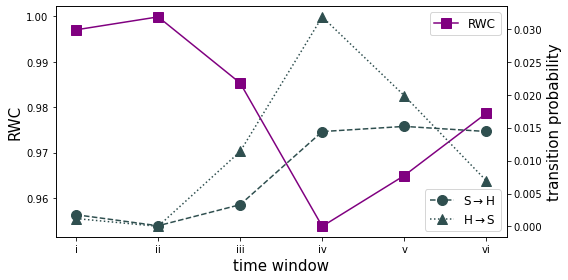

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
#t = np.arange(0, 6, 1)
t = ['i','ii','iii','iv','v','vi']
data1 = rwcs 
data2 = rls 
data3 = lrs 


fig, ax1 = plt.subplots()
fig.set_size_inches(8,4)

color = 'purple'

ax1.set_xlabel('time window', fontsize = 15)
ax1.set_ylabel('RWC', color='black',fontsize=15)
ax1.plot(t, data1, marker='s', linestyle='-' ,markersize=10, color=color, label='RWC')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(fontsize=12)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
color1 = 'darkslategray'
color2 = 'darkslategray'
ax2.set_ylabel('transition probability', color='black', fontsize=15)
ax2.plot(t, data2, color=color1, marker='o', linestyle='--', markersize=10, label='S'+r'$\rightarrow$'+'H')
ax2.plot(t, data3, color=color2, marker='^', linestyle=':', markersize=10, label='H'+r'$\rightarrow$'+'S')
ax2.legend(loc='lower right', fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clippe
plt.savefig('/../figures/RWC_HSSH_probs.pdf')
plt.show()